# `CNRatioAnomalyModel` Tutorial

Trey V. Wenger (c) December 2024

`CNRatioAnomalyModel` is like `CNRatioLTEModel`, but allows for non-LTE variations in the 12CN hyperfine component optical depths, often called "hyperfine anomalies." We assume that 13CN does not suffer from similar effects. This notebook demonstrates this model and is otherwise nearly identical to the `CNRatioLTEModel` notebook.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+2.g3f0e12d.dirty


## Simulating Data

300
350


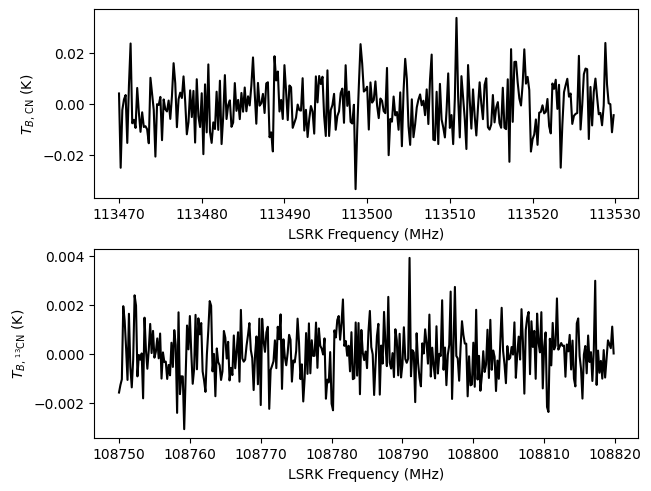

In [2]:
from bayes_spec import SpecData

# spectral axis definitions
freq_axis_12CN = np.arange(113470, 113530, 0.2) # MHz
freq_axis_13CN = np.arange(108750, 108820, 0.2)
print(len(freq_axis_12CN))
print(len(freq_axis_13CN))

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise_12CN = 0.01 # K
noise_13CN = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN = noise_12CN * np.random.randn(len(freq_axis_12CN)) # K
brightness_data_13CN = noise_13CN * np.random.randn(len(freq_axis_13CN)) # K

# Our model only expects two observations named "12CN" and "13CN"
observation_12CN = SpecData(
    freq_axis_12CN,
    brightness_data_12CN,
    noise_12CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    brightness_data_13CN,
    noise_13CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
dummy_data = {"12CN": observation_12CN, "13CN": observation_13CN}

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, dummy_data["12CN"].brightness, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, dummy_data["13CN"].brightness, 'k-')
axes[0].set_xlabel(dummy_data["12CN"].xlabel)
axes[1].set_xlabel(dummy_data["13CN"].xlabel)
axes[0].set_ylabel(dummy_data["12CN"].ylabel)
_ = axes[1].set_ylabel(dummy_data["13CN"].ylabel)

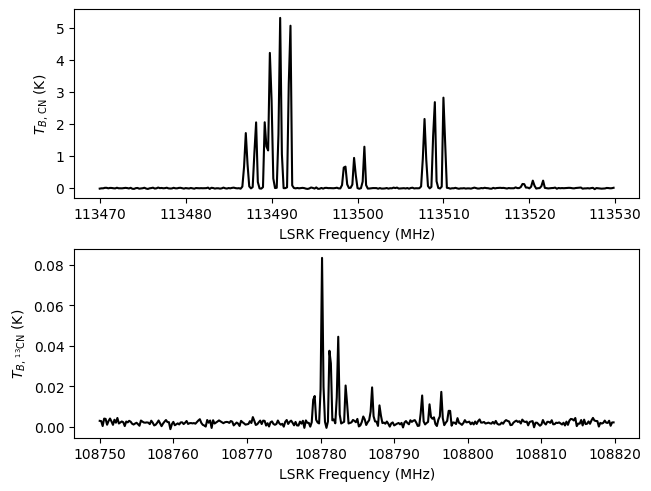

In [3]:
from bayes_cn_hfs import CNRatioAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = CNRatioAnomalyModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total_12CN = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal FWHM prior (km/s)
    prior_log10_anomaly_12CN = 0.1, # width of CN hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total_12CN = None, # do not assume tau_total
    fix_log10_Tkin = None, # do not assume Tkin
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

log10_anomaly_12CN = np.zeros((len(model.mol_data_12CN['freq']), n_clouds))
for i, freq in enumerate(model.mol_data_12CN['freq']):
    if freq == 113499.643:
        log10_anomaly_12CN[i] = -0.2
    elif freq == 113508.934:
        log10_anomaly_12CN[i] = 0.2

sim_params = {
    "tau_total_12CN": [1.0, 2.0, 0.5],
    "log10_Tkin": [1.5, 1.25, 1.75],
    "velocity": [-3.0, 0.0, 3.0],
    "fwhm_nonthermal": [0.25, 0.5, 0.75],
    "fwhm_L": 0.0,
}
sim_params_12CN = sim_params.copy()
sim_params_12CN.update({
    "log10_anomaly_12CN": log10_anomaly_12CN,
    "baseline_12CN_norm": [-1.0], # normalized baseline coefficients
})
sim_params_13CN = sim_params.copy()
sim_params_13CN.update({
    "ratio_13C_12C": [0.01, 0.02, 0.005],
    "baseline_13CN_norm": [2.0], # normalized baseline coefficients
})

sim_brightness_12CN = model.model["12CN"].eval(sim_params_12CN)
sim_brightness_13CN = model.model["13CN"].eval(sim_params_13CN)

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, sim_brightness_12CN, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, sim_brightness_13CN, 'k-')
axes[0].set_xlabel(dummy_data["12CN"].xlabel)
axes[1].set_xlabel(dummy_data["13CN"].xlabel)
axes[0].set_ylabel(dummy_data["12CN"].ylabel)
_ = axes[1].set_ylabel(dummy_data["13CN"].ylabel)

In [4]:
# Now we pack the simulated spectra into a new SpecData instance
observation_12CN = SpecData(
    freq_axis_12CN,
    sim_brightness_12CN,
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    sim_brightness_13CN,
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
data = {"12CN": observation_12CN, "13CN": observation_13CN}

## Model Definition

Including hyperfine anomalies limits our ability to constrain either the excitation temperature or the optical depth. We thus fix both the optical depth and the kinetic temperature. Except in the optically thick limit, that's the best we can do.

In [5]:
# Initialize and define the model
model = CNRatioAnomalyModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal FWHM prior (km/s)
    prior_log10_anomaly_12CN = 0.1, # width of CN hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total_12CN = 1.0, # fix tau_total
    fix_log10_Tkin = 1.5, # fix log10_Tkin (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

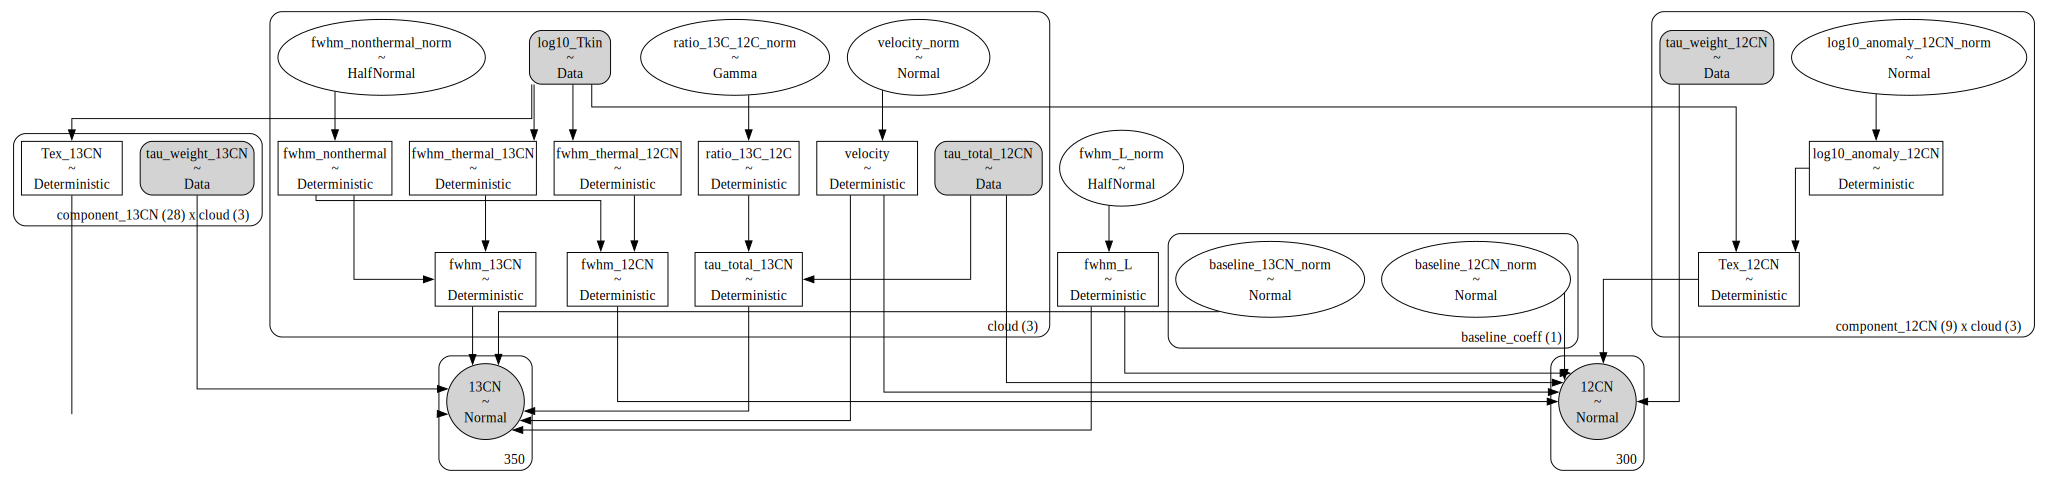

In [6]:
# Plot model graph
model.graph().render('cn_ratio_anomaly_model', format='png')
model.graph()

In [7]:
# model string representation
print(model.model.str_repr())

     baseline_12CN_norm ~ Normal(0, 1)
     baseline_13CN_norm ~ Normal(0, 1)
          velocity_norm ~ Normal(0, 1)
   fwhm_nonthermal_norm ~ HalfNormal(0, 1)
            fwhm_L_norm ~ HalfNormal(0, 1)
     ratio_13C_12C_norm ~ Gamma(2, f())
log10_anomaly_12CN_norm ~ Normal(0, 1)
               velocity ~ Deterministic(f(velocity_norm))
      fwhm_thermal_12CN ~ Deterministic(f())
      fwhm_thermal_13CN ~ Deterministic(f())
        fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
              fwhm_12CN ~ Deterministic(f(fwhm_nonthermal_norm))
              fwhm_13CN ~ Deterministic(f(fwhm_nonthermal_norm))
                 fwhm_L ~ Deterministic(f(fwhm_L_norm))
          ratio_13C_12C ~ Deterministic(f(ratio_13C_12C_norm))
         tau_total_13CN ~ Deterministic(f(ratio_13C_12C_norm))
     log10_anomaly_12CN ~ Deterministic(f(log10_anomaly_12CN_norm))
               Tex_12CN ~ Deterministic(f(log10_anomaly_12CN_norm))
               Tex_13CN ~ Deterministic(f())
            

Sampling: [12CN, 13CN, baseline_12CN_norm, baseline_13CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_anomaly_12CN_norm, ratio_13C_12C_norm, velocity_norm]


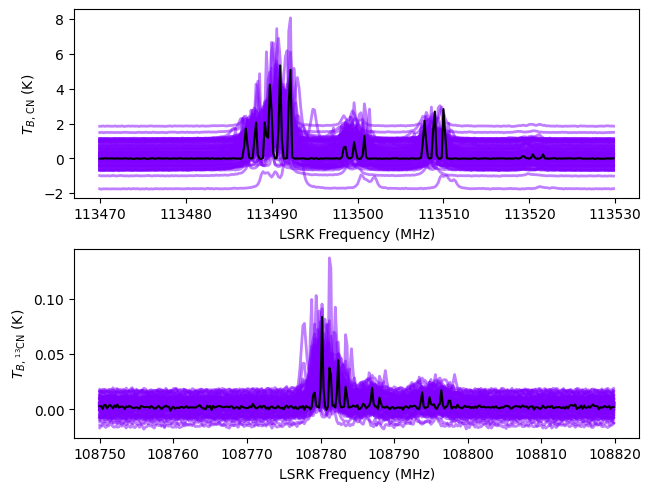

In [8]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [9]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6500
Interrupted at 6,499 [6%]: Average Loss = 2.1929e+05


Output()

Runtime: 1.94 minutes


In [10]:
# posterior samples stored in model.trace.posterior
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
velocity[0],2.993,0.001,2.991,2.996,0.000,0.000,1026.0,878.0,NaN
velocity[1],-3.010,0.001,-3.012,-3.008,0.000,0.000,816.0,944.0,NaN
velocity[2],0.002,0.001,-0.001,0.004,0.000,0.000,837.0,916.0,NaN
fwhm_thermal_12CN[0],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal_12CN[1],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal_12CN[2],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal_13CN[0],0.232,0.000,0.232,0.232,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal_13CN[1],0.232,0.000,0.232,0.232,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal_13CN[2],0.232,0.000,0.232,0.232,0.000,0.000,1000.0,1000.0,NaN
fwhm_nonthermal[0],0.767,0.002,0.763,0.772,0.000,0.000,998.0,835.0,NaN


Sampling: [12CN, 13CN]


Output()

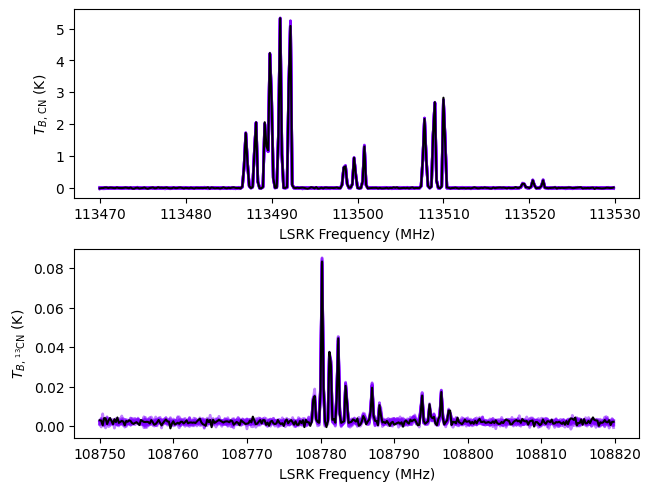

In [11]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [12]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6500
Interrupted at 6,499 [6%]: Average Loss = 2.1929e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, baseline_13CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, ratio_13C_12C_norm, log10_anomaly_12CN_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 238 seconds.


Adding log-likelihood to trace


Output()

Runtime: 6.38 minutes


In [13]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [14]:
pm.summary(model.trace.solution_0, var_names=model.cloud_deterministics)

/var/lib/condor/execute/slot1/dir_3869349/.local/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/var/lib/condor/execute/slot1/dir_3869349/.local/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
velocity[0],3.000,0.001,2.999,3.002,0.000,0.000,17616.0,5242.0,1.0
velocity[1],-3.000,0.000,-3.000,-2.999,0.000,0.000,12038.0,5796.0,1.0
velocity[2],0.001,0.001,-0.001,0.002,0.000,0.000,15150.0,5978.0,1.0
fwhm_thermal_12CN[0],0.236,0.000,0.236,0.236,0.000,0.000,8000.0,8000.0,NaN
fwhm_thermal_12CN[1],0.236,0.000,0.236,0.236,0.000,0.000,8000.0,8000.0,NaN
fwhm_thermal_12CN[2],0.236,0.000,0.236,0.236,0.000,0.000,8000.0,8000.0,NaN
fwhm_thermal_13CN[0],0.232,0.000,0.232,0.232,0.000,0.000,8000.0,8000.0,NaN
fwhm_thermal_13CN[1],0.232,0.000,0.232,0.232,0.000,0.000,8000.0,8000.0,NaN
fwhm_thermal_13CN[2],0.232,0.000,0.232,0.232,0.000,0.000,8000.0,8000.0,NaN
fwhm_nonthermal[0],0.768,0.002,0.764,0.773,0.000,0.000,10262.0,6351.0,1.0


Sampling: [12CN, 13CN]


Output()

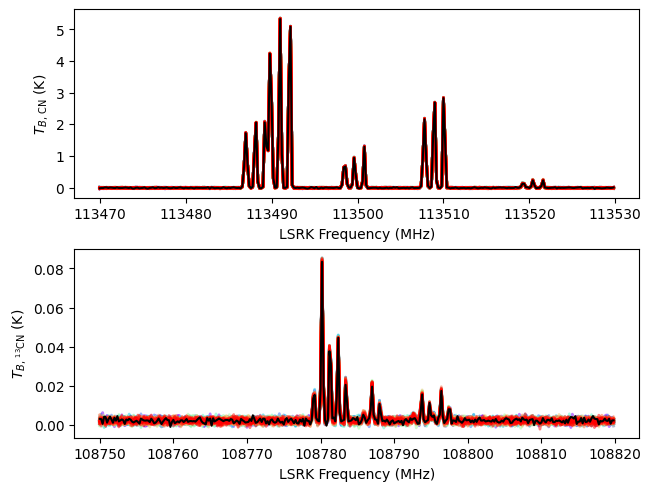

In [15]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

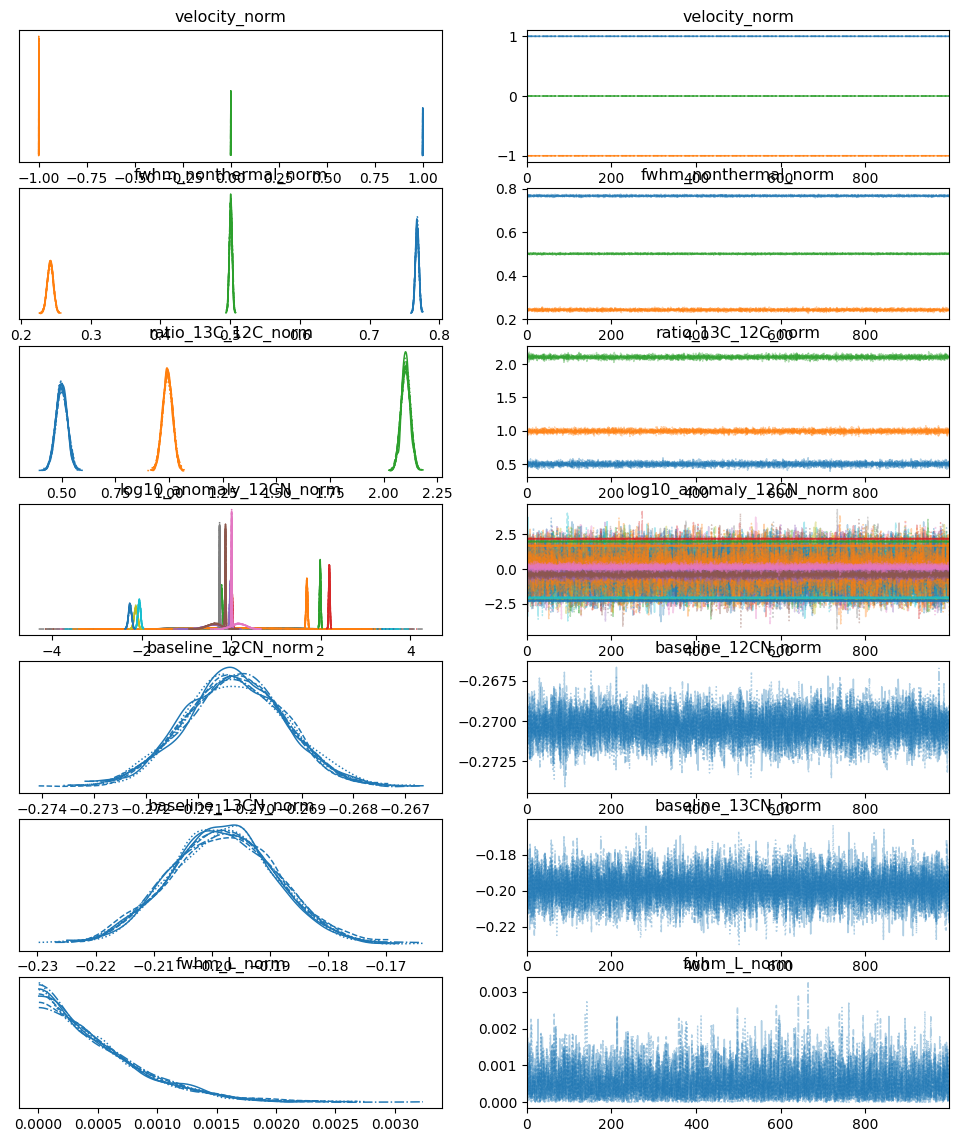

In [16]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [17]:
model.cloud_deterministics

['velocity',
 'fwhm_thermal_12CN',
 'fwhm_thermal_13CN',
 'fwhm_nonthermal',
 'fwhm_12CN',
 'fwhm_13CN',
 'ratio_13C_12C',
 'tau_total_13CN',
 'log10_anomaly_12CN',
 'Tex_12CN',
 'Tex_13CN']

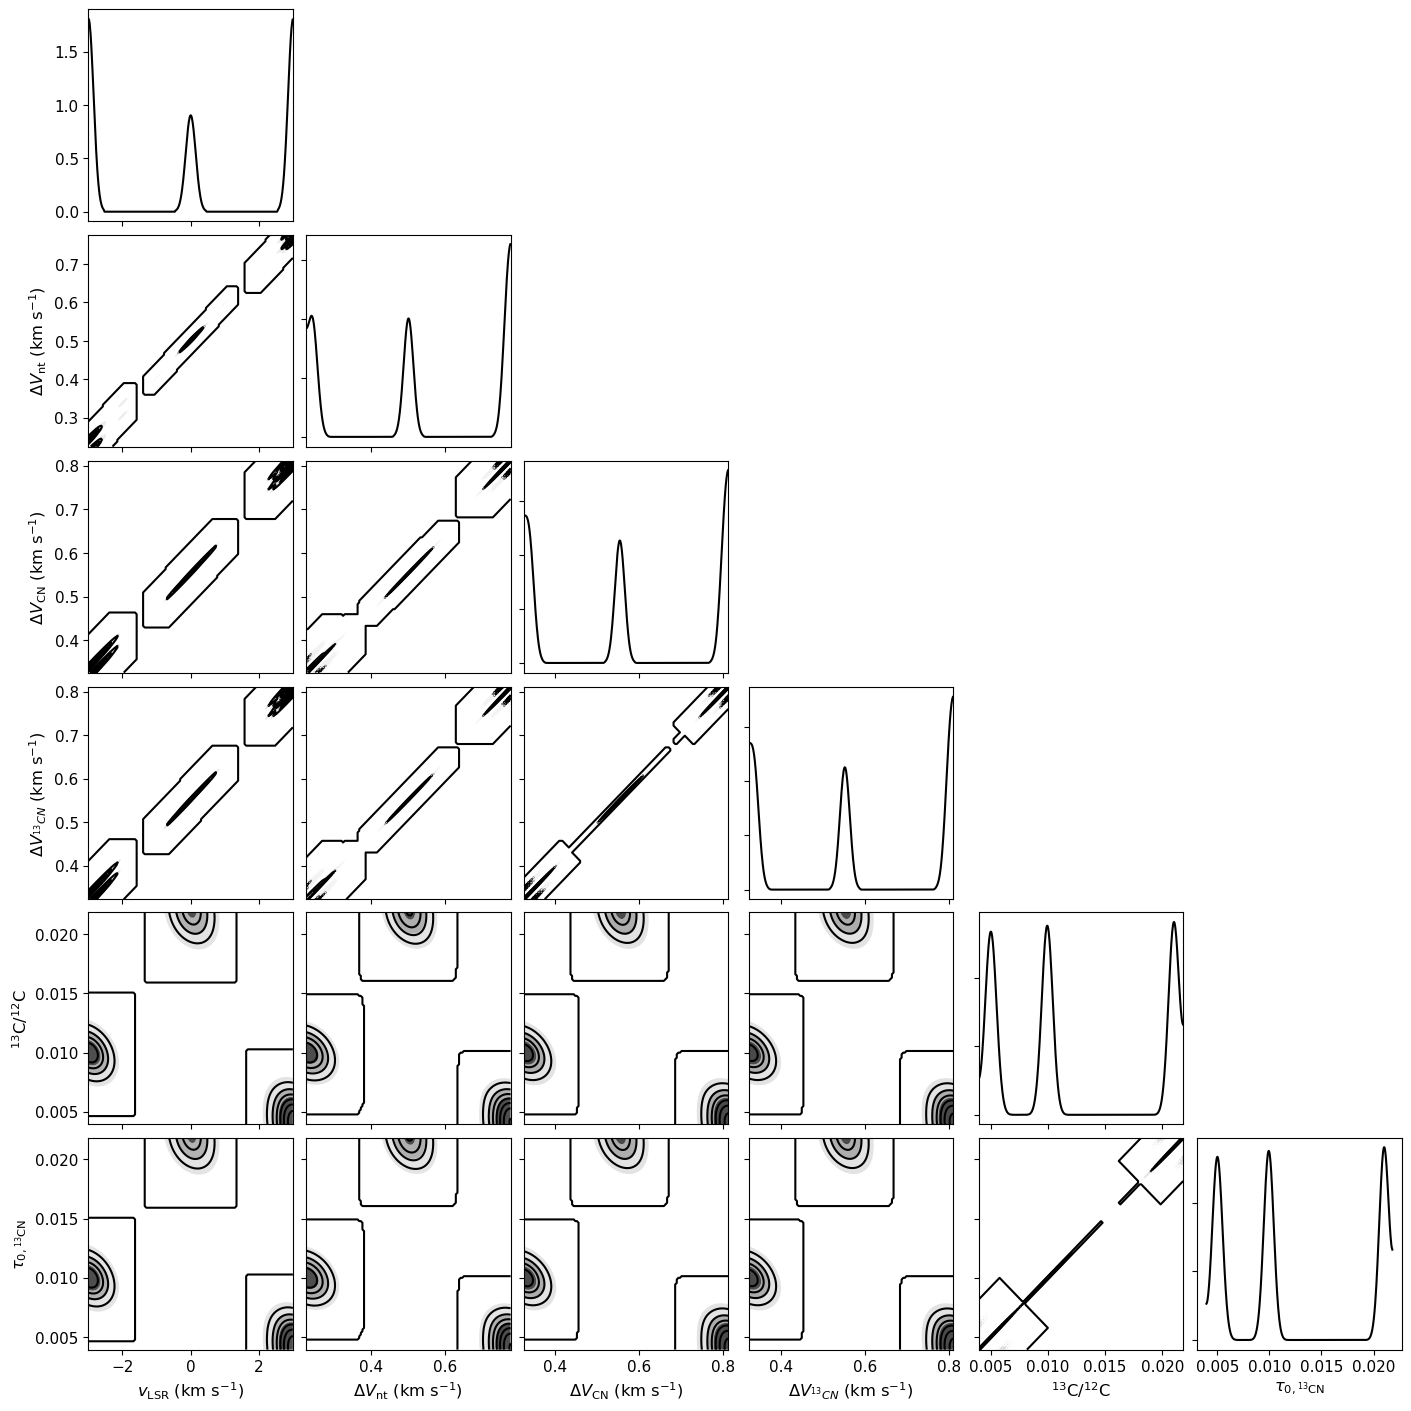

In [18]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics if param not in 
    ["Tex_12CN", "Tex_13CN", "fwhm_thermal_12CN", "fwhm_thermal_13CN", "log10_anomaly_12CN"]
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [20]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -5514.8714155696725


,mean,sd,hdi_16%,hdi_84%
velocity[0],3.000,0.001,3.000,3.001
velocity[1],-3.000,0.000,-3.000,-2.999
velocity[2],0.001,0.001,0.000,0.001
fwhm_thermal_12CN[0],0.236,0.000,0.236,0.236
fwhm_thermal_12CN[1],0.236,0.000,0.236,0.236
fwhm_thermal_12CN[2],0.236,0.000,0.236,0.236
fwhm_thermal_13CN[0],0.232,0.000,0.232,0.232
fwhm_thermal_13CN[1],0.232,0.000,0.232,0.232
fwhm_thermal_13CN[2],0.232,0.000,0.232,0.232
fwhm_nonthermal[0],0.768,0.002,0.766,0.771
